In [1]:
import glob
import os
import random
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
from PIL import Image

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 2913
fix_seed(SEED)

In [3]:
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)
voc_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
voc_filename = "VOCtrainval_11-May-2012.tar"
if not os.path.exists(os.path.join(data_dir, voc_filename)):
    with open(os.path.join(data_dir, voc_filename), "wb") as f:
        res = requests.get(voc_url, stream=True)
        f.write(res.raw.read())
    tar_path = os.path.join(data_dir, voc_filename)
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(data_dir)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 3-1 セマンティックセグメンテーションとは？

セマンティックセグメンテーションとは、画像内の各ピクセルに対して、物体の分類を行うタスク。

以下のデータの可視化で詳細がわかるはず。

### ファイルの準備

In [5]:
img_paths = glob.glob(os.path.join(data_dir, "VOCdevkit/VOC2012/JPEGImages/*.jpg"))
len(img_paths)

17125

In [6]:
anno_paths = glob.glob(
    os.path.join(data_dir, "VOCdevkit/VOC2012/SegmentationClass/*.png")
)
len(anno_paths)

2913

In [7]:
with open(
    os.path.join(data_dir, "VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt")
) as f:
    train_ids = f.readlines()
with open(
    os.path.join(data_dir, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt")
) as f:
    val_ids = f.readlines()
train_ids = [id_.strip() for id_ in train_ids]
val_ids = [id_.strip() for id_ in val_ids]
print(f"train_ids: {len(train_ids)}")
print(f"val_ids: {len(val_ids)}")

train_ids: 1464
val_ids: 1449


In [8]:
train_img_paths = [
    path for path in img_paths if os.path.basename(path).split(".")[0] in train_ids
]
train_img_paths = sorted(train_img_paths)
val_img_paths = [
    path for path in img_paths if os.path.basename(path).split(".")[0] in val_ids
]
val_img_paths = sorted(val_img_paths)
train_anno_paths = [
    path for path in anno_paths if os.path.basename(path).split(".")[0] in train_ids
]
train_anno_paths = sorted(train_anno_paths)
val_anno_paths = [
    path for path in anno_paths if os.path.basename(path).split(".")[0] in val_ids
]
val_anno_paths = sorted(val_anno_paths)

### データの確認

データを可視化して、Semantic Segmentationの理解を深める。

アノテーションのデータは、3チャネルではなく1チャネルであることに注意する。書く値に対応するクラスは[公式サイト](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html)に記載されている。

なお、255は"void or unlabelled"なので、0(background)にしておくのが良いだろう。

In [9]:
train_img_paths[0]

'../data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'

In [10]:
train_anno_paths[0]

'../data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'

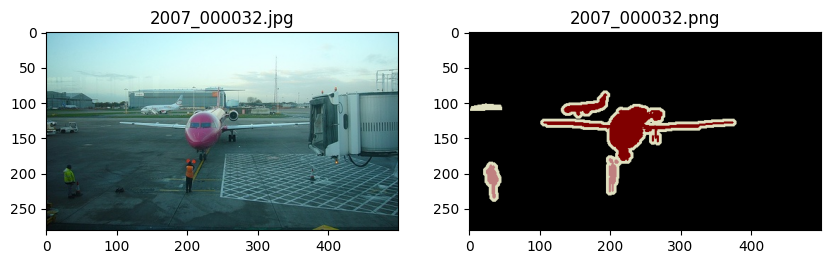

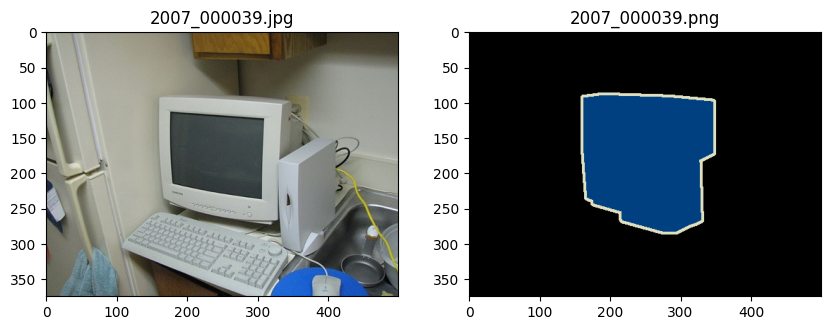

In [11]:
indices = [0, 1]
for index in indices:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(train_img_paths[index]))
    axes[0].set_title(os.path.basename(train_img_paths[index]))
    axes[1].imshow(Image.open(train_anno_paths[index]))
    axes[1].set_title(os.path.basename(train_anno_paths[index]))
    plt.show()

## 3-2 DataLoaderの作成

基本に忠実に作成すればいいが、DataTransformは書籍と発想が違うので注意。オリジナル画像とアノテーション画像を結合して、channelが4の画像として扱ってから、`torchvision.transform.*`の各関数を適用すれば、オリジナルと画像に対して同じ処理を施すことができて便利である。ただし、Normlaizeはアノテーションに適用してはいけないので注意。

以下の点に注意する。

- 先述した通り、255は0に変換する。

In [12]:
class VocSegDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, anno_paths, phase="train", transform=None):
        super().__init__()
        self.img_paths = img_paths
        self.anno_paths = anno_paths
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        self.phase = phase
        self.transform = transform
        if len(img_paths) != len(anno_paths):
            raise ValueError("The number of images and annotations must be the same.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        anno_path = self.anno_paths[idx]
        img = torchvision.io.read_image(img_path, mode=torchvision.io.ImageReadMode.RGB)
        anno = torchvision.io.read_image(
            anno_path, mode=torchvision.io.ImageReadMode.UNCHANGED
        )
        anno[anno == 255] = 0
        if self.transform:
            img, anno = self.transform(img, anno, phase=self.phase)
        return img, anno

### DataTransformの実装

以下の点に注意して実装する。なお、書籍のようにPILやCV2を多用していると、何が何だかわからなくなるので、`torchvision.transforms`を極力使う方針とする。

- `torchvision.transforms`の関数を使いながら、画像とアノテーションに同じ処理を施したい。ただ、例えば`RandomResizedCrop`は、ランダムに処理が適用されるので注意が必要。ここで、画像とアノテーションを`concat`しておくと、画像とアノテーションに同じ処理を施せる。
- `torchvision.transforms.RandomRotation`では以下のように、回転後に邪魔な部分が残るので、`RandomRotationCrop`を独自に実装する。
- `RandomResizedCrop`は、`interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT`を引数に渡しておかないと、アノテーションが整数ではなくなってしまうので注意。`Resize`も同様。

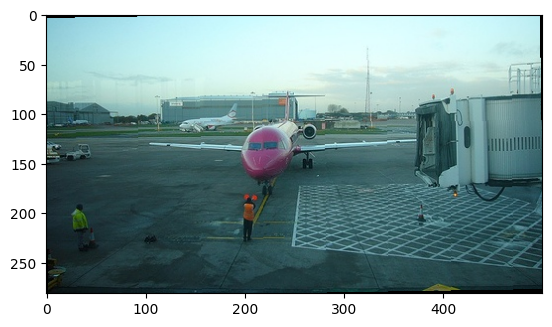

In [13]:
# RandomRotation will leave black areas around the image.
img = torchvision.io.read_image(
    train_img_paths[0], mode=torchvision.io.ImageReadMode.RGB
)
img = torchvision.transforms.RandomRotation(45)(img)
plt.imshow(img.permute(1, 2, 0))

In [14]:
import math


class RandomRotationCrop(torchvision.transforms.RandomRotation):
    """
    Randomly crop the image so that the rotated image does not include black pixels.
    Note: https://stackoverflow.com/questions/21346670/cropping-rotated-image-with-same-aspect-ratio
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.expand = False

    def rotatedRectWithMaxArea(self, w, h, angle):
        if w <= 0 or h <= 0:
            return 0, 0

        width_is_longer = w >= h
        side_long, side_short = (w, h) if width_is_longer else (h, w)

        # since the solutions for angle, -angle and 180-angle are all the same,
        # if suffices to look at the first quadrant and the absolute values of sin,cos:
        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.0 * sin_a * cos_a * side_long or abs(sin_a - cos_a) < 1e-10:
            # half constrained case: two crop corners touch the longer side,
            #   the other two corners are on the mid-line parallel to the longer line
            x = 0.5 * side_short
            wr, hr = (
                (x / sin_a, x / cos_a) if width_is_longer else (x / cos_a, x / sin_a)
            )
        else:
            # fully constrained case: crop touches all 4 sides
            cos_2a = cos_a * cos_a - sin_a * sin_a
            wr, hr = (w * cos_a - h * sin_a) / cos_2a, (h * cos_a - w * sin_a) / cos_2a

        return wr, hr

    def forward(self, img):
        angle = self.get_params(self.degrees)
        angle_rad = math.radians(angle)
        if not 0 <= angle <= 90:
            raise ValueError("Angle must be 0 <= angle <= 90.")
        h, w = img.shape[1:]
        aspect_ratio = w / h
        img_rotated = torchvision.transforms.functional.rotate(
            img, angle, self.interpolation, self.expand, self.center, self.fill
        )
        h_crop = h / (aspect_ratio * math.sin(angle_rad) + math.cos(angle_rad))
        w_crop = h_crop * aspect_ratio
        return torchvision.transforms.functional.center_crop(
            img_rotated, (math.floor(h_crop), math.floor(w_crop))
        )

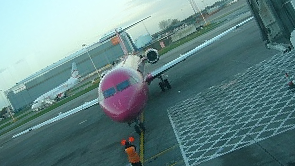

In [15]:
img = torchvision.io.read_image(
    train_img_paths[0], mode=torchvision.io.ImageReadMode.RGB
)
img = RandomRotationCrop((0, 45))(img)
display(torchvision.transforms.functional.to_pil_image(img))

In [16]:
class VocDataTransform:
    def __init__(self, input_size, color_mean, color_std):
        self.common_transform = {
            "train": torchvision.transforms.Compose(
                [
                    RandomRotationCrop((0, 45)),
                    torchvision.transforms.RandomResizedCrop(
                        input_size,
                        antialias=False,
                        interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                    ),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.Resize(
                        (input_size, input_size),
                        interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                    ),
                ]
            ),
            "val": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((input_size, input_size)),
                ]
            ),
        }
        self.img_transform = {
            "train": torchvision.transforms.Compose(
                [
                    torchvision.transforms.ConvertImageDtype(torch.float32),
                    torchvision.transforms.Normalize(color_mean, color_std),
                ]
            ),
            "val": torchvision.transforms.Compose(
                [
                    torchvision.transforms.ConvertImageDtype(torch.float32),
                    torchvision.transforms.Normalize(color_mean, color_std),
                ]
            ),
        }

    def __call__(self, img, anno, phase="train"):
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        # img = torchvision.transforms.functional.to_tensor(img)
        # anno = torchvision.transforms.functional.to_tensor(anno)
        concat_img_anno = torch.cat([img, anno], dim=0)
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        concat_img_anno = self.common_transform[phase](concat_img_anno)
        # img= self.common_transform[phase](img)
        # anno = self.common_transform[phase](anno)
        img = concat_img_anno[:3]
        anno = concat_img_anno[3:]
        img = self.img_transform[phase](img)
        return img, anno

VocDataTransformの確認

In [17]:
transform = VocDataTransform(457, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_dataset = VocSegDataset(
    train_img_paths, train_anno_paths, phase="train", transform=transform
)
val_dataset = VocSegDataset(
    val_img_paths, val_anno_paths, phase="val", transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


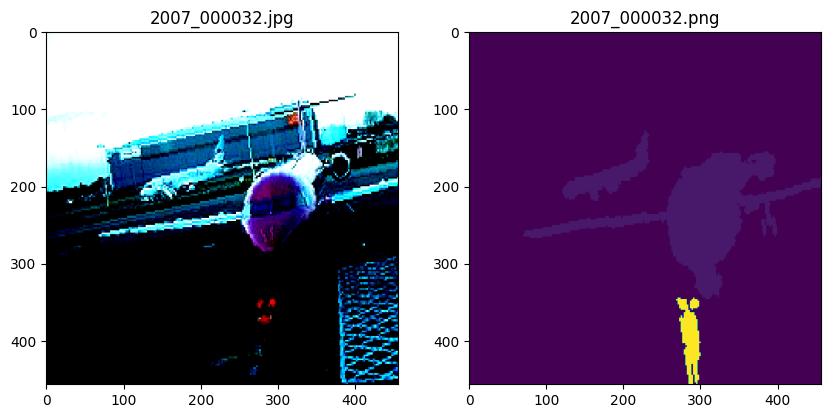

torch.Size([1, 457, 457])

tensor([ 0,  1, 15], dtype=torch.uint8)

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
index = 0
img, anno = train_dataset[index]
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title(os.path.basename(train_img_paths[index]))
axes[1].imshow(torchvision.transforms.functional.to_pil_image(anno))
axes[1].set_title(os.path.basename(train_anno_paths[index]))
plt.show()
display(anno.shape)
anno.unique()

In [19]:
batch_size = 8
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## 3-3 PSPNetのネットワーク構成と実装

```mermaid
flowchart LR; 
    img(img)
    E(Encoder)
    PP(Pyramid Pooling)
    D(Decoder)
    A(AuxLoss)
    output(output)
    output_a(output by AuxLoss)
    img --(3,475,475)-->E --(2048,60,60)-->PP--(4096,60,60)-->D--(21,475,475)-->output
    E--(1024,60,60)-->A-->output_a
```

AuxLossは学習時のみ使用され、推論時には使用されない。前半のEncoder部分で学習に失敗していると、後段での学習も当然失敗しているので、前半部分のロスを取り出すことで学習を効率化している、と自分は理解した。

## 3-4 Encoder(Feature)モジュール

```mermaid
flowchart LR;
    img(img)
    FeatureMapConv(FeatureMapConv)
    PSP1(ResidualBlockPSP)
    PSP2(ResidualBlockPSP)
    PSPd1("ResidualBlockPSP(dilated)")
    PSPd2("ResidualBlockPSP(dilated)")
    Decoder(Decoder)

    img--(3,475,475)-->FeatureMapConv

    subgraph Encoder
        FeatureMapConv--(128,119,119)-->PSP1--(256,119,119)-->PSP2--(512,60,60)-->PSPd1--(1024,60,60)-->PSPd2
    end

    PSPd2 ---> Decoder
```

上記のネットワークを実装していく。なお、書籍のクラス名はPEPに沿っていなくて気持ち悪いので、適宜修正している。

Encoderの特徴として、チャネル数(dim=0)を増やすとともに、画像部分のサイズ(dim=1,2)を小さくしていることが挙げられる。
このようにすることで、画像全体に渡る大雑把な特徴量の多数の取得が期待できる。

#### 

#### FeatureMapConvの実装

```mermaid
flowchart LR;
    img(img)
    CBNR1(Conv2dBatchNormRelu)
    CBNR2(Conv2dBatchNormRelu)
    CBNR3(Conv2dBatchNormRelu)
    P(MaxPooling)

    img --(3,475,475)--> CBNR1
    subgraph FeatureMapConv
        CBNR1--(64,238,238)-->CBNR2--(64,238,238)-->CBNR3--(128,238,238)-->P
    end

    PSP(ResidualBlockPSP)
    P--(128,119,119)-->PSP
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    C3("Conv2d(kernel_size=3,stride=2,padding=1,dilation=1)")
    N(BatchNorm2d)
    R(ReLU)
    
    None1-->C3
    R-->None2
    subgraph Conv2dBatchNormRelu
        C3-->N-->R
    end
```

<e>バッチノーマライゼーション部分にはバイアス項が含まれるため、Conv2Dのバイアスを設定する必要がないことに注意。

In [30]:
class Conv2dBatchNorm(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            torch.nn.BatchNorm2d(out_channels),
        )

In [31]:
class Conv2dBatchNormReLU(Conv2dBatchNorm):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.add_module("ReLU", torch.nn.ReLU())

#### 

In [32]:
class FeatureMapConv(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            Conv2dBatchNormReLU(3, 64, 3, stride=2, padding=1, bias=False),
            Conv2dBatchNormReLU(64, 64, 3, stride=1, padding=1, bias=False),
            Conv2dBatchNormReLU(64, 128, 3, stride=1, padding=1, bias=False),
            torch.nn.AdaptiveMaxPool2d(119),
        )

In [33]:
dummy_img = torch.randn(batch_size, 3, 457, 457)
model = FeatureMapConv()
output = model(dummy_img)
print(output.shape)
assert output.shape == torch.Size([batch_size, 128, 119, 119])
del dummy_img, model, output

torch.Size([8, 128, 119, 119])


### ResidualBlockPSP

```mermaid
flowchart LR;
    None1( )
    None2( )
    1(BottleNeckPSP)
    2(BottleNeckIdentifyPSP)
    3(BottleNeckPSP)
    None1-->1
    3-->None2
    subgraph ResidualBlockPSP
        1-->2-->3
    end
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    1("Conv2DBatchNormReLU, kernel_size=1")
    2("Conv2DBatchNormReLU, kernel_size=3")
    3("Conv2DBatchNorm, kernel_size=1")
    4("Conv2DBatchNorm, kernel_size=1")
    R(ReLU)

    None1-->1
    None1-->4
    R-->None2
    subgraph BottleNeckPSP
        1-->2-->3-->R
        4-->R
    end
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    1("Conv2DBatchNormReLU, kernel_size=1")
    2("Conv2DBatchNormReLU, kernel_size=3")
    3("Conv2DBatchNorm, kernel_size=1")
    R(ReLU)

    None1-->1
    None1-->R
    R-->None2
    subgraph BottleNeckIdentifyPSP
        1-->2-->3-->R
    end
```

BottleNeckIdentifyPSPはスキップ結合を使用している。(BottleNeckPSPは部分的にスキップ結合していると言える？)

スキップ結合のメリットは以下。

- 全体で層が深い時でも勾配消失問題を避けることができる。
- 入力をx, 学習すべき出力をyとした時、スキップ結合があることに注意すると、モデルが学習するのはy-xになり、学習が楽になる。ネガティブフィードバックが働いていると考えるとわかりやすい気がする。

In [ ]:
class BottleNeckPSP(torch.nn.Sequential):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super().__init__(
            Conv2dBatchNormReLU(
                in_channels, mid_channels, 1, stride=1, padding=0, bias=False
            ),
            Conv2dBatchNormReLU(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                bias=False,
            ),
            Conv2dBatchNormReLU(
                mid_channels, in_channels, 1, stride=1, padding=0, bias=False
            ),
            torch.nn.ReLU(),
        )